# Drone Model-Predictive Control

## Package Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from pydrake.all import (
    AddMultibodyPlantSceneGraph, DiagramBuilder,DirectCollocation, 
    FiniteHorizonLinearQuadraticRegulatorOptions, FindResourceOrThrow, LinearSystem,
    LogVectorOutput, MultibodyPlant, MakeFiniteHorizonLinearQuadraticRegulator,
    MathematicalProgram, MeshcatVisualizerParams, MeshcatVisualizerCpp, Parser, 
    plot_system_graphviz, PiecewisePolynomial, RandomSource, RandomDistribution, 
    RigidTransform, Role, RotationMatrix, SceneGraph, Simulator, Solve, StartMeshcat, 
    TrajectorySource, Trajectory, VectorSystem )

from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController)

from underactuated.meshcat_cpp_utils import MeshcatSliders





In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://7a2da9b8-cd38-4703-b181-4b0e0b197067.deepnoteproject.com/7000/


## Wind Turbulence Model 

A standard mathematical model used to approximate continuous wind gusts is the Dryden Wind Turbulence Model.

sigma_u = 2.5737730694567573, L_u = 505.1693349051267
sigma_v = 2.5737730694567573, L_v = 505.1693349051267 
sigma_w = 1.5, L_w = 100 
vehicle_speed = 5
H_ug_gain = 20.64162108931089
TransferFunctionContinuous(
array([0.20430398]),
array([1.        , 0.00989767]),
dt: None
)


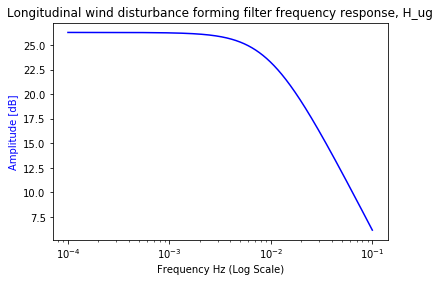

H_vg_gain = 103.20810544655444
TransferFunctionContinuous(
array([0.88466218, 0.00252767]),
array([1.00000000e+00, 9.89767125e-03, 2.44909740e-05]),
dt: None
)


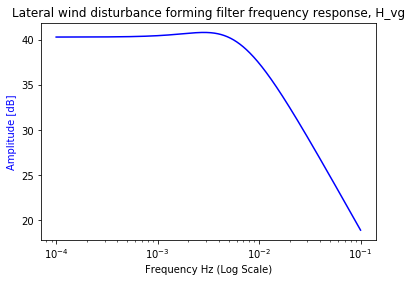

H_wg_gain = 26.76186174229157
TransferFunctionContinuous(
array([1.15882261, 0.01672616]),
array([1.00e+00, 5.00e-02, 6.25e-04]),
dt: None
)


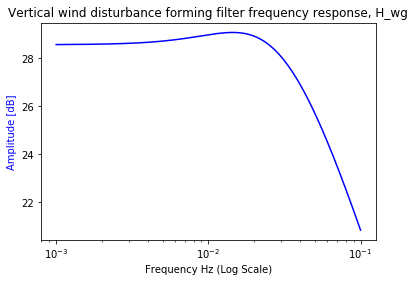

H_pg_gain = 0.4947011225374322
TransferFunctionContinuous(
array([0.03321948]),
array([1.        , 0.39269908]),
dt: None
)


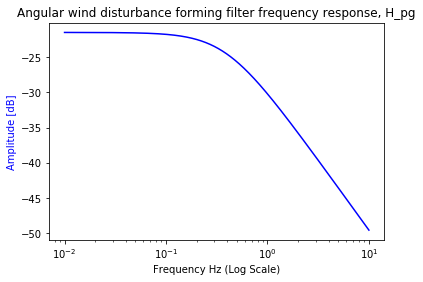

H_wg_gain = 26.76186174229157
TransferFunctionContinuous(
array([0.09101371, 0.00131367, 0.        ]),
array([1.00000000e+00, 4.42699082e-01, 2.02599541e-02, 2.45436926e-04]),
dt: None
)


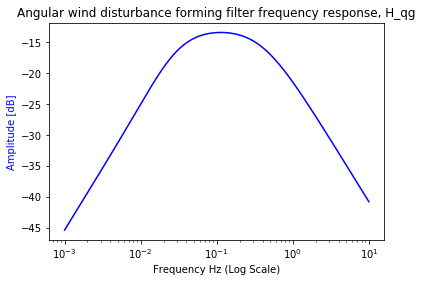

H_vg_gain = 103.20810544655444
TransferFunctionContinuous(
array([-0.09264161, -0.0002647 ,  0.        ]),
array([1.00000000e+00, 5.33496447e-01, 5.20689952e-03, 1.28234440e-05]),
dt: None
)


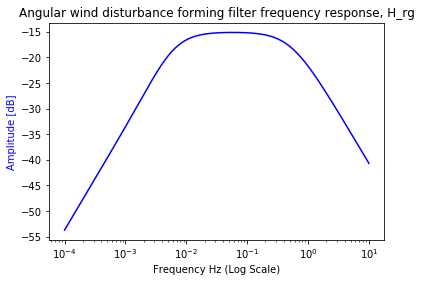

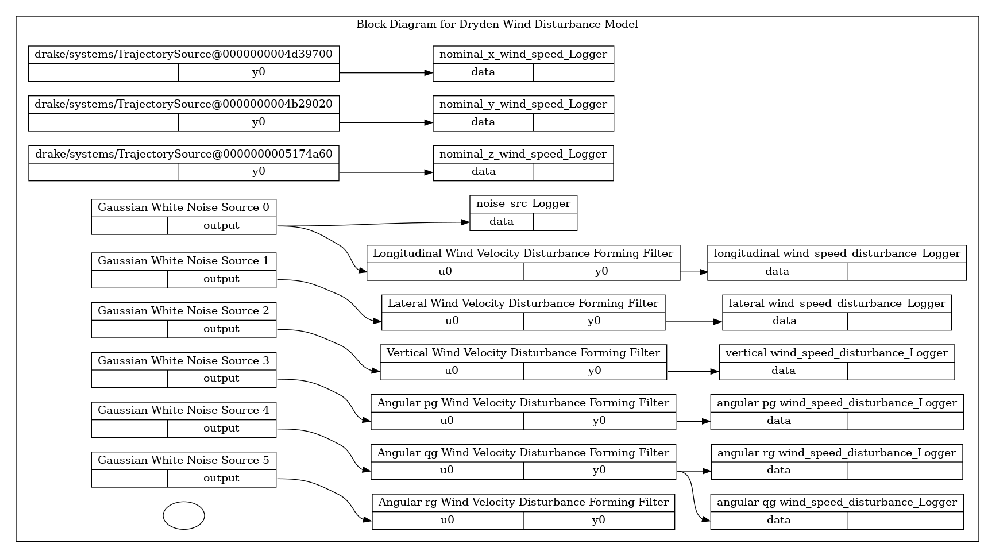

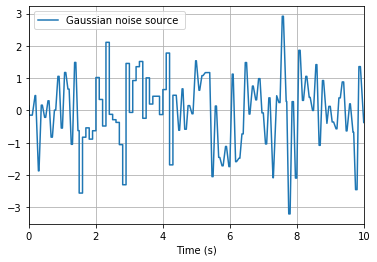

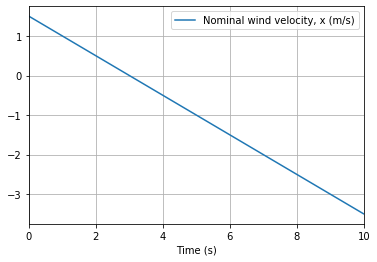

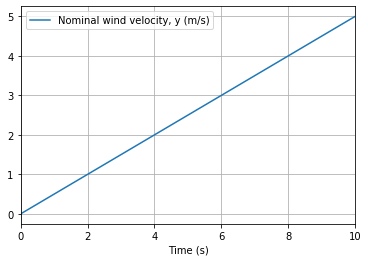

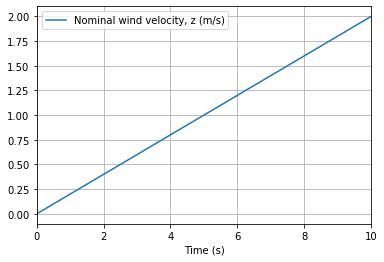

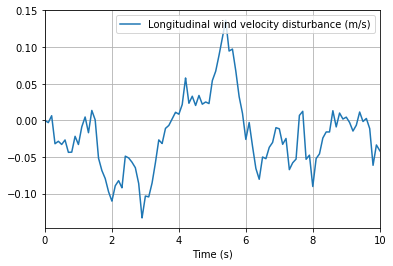

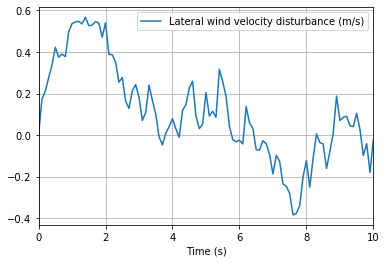

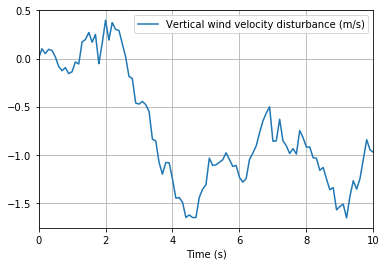

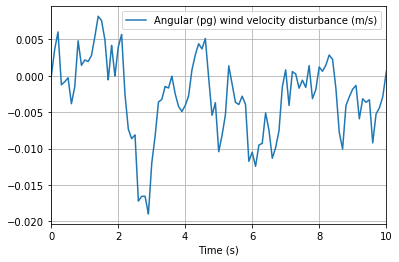

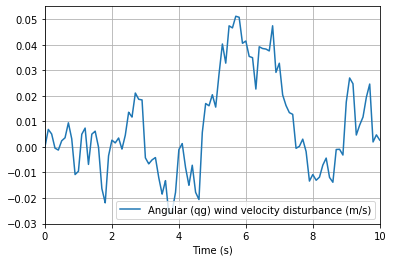

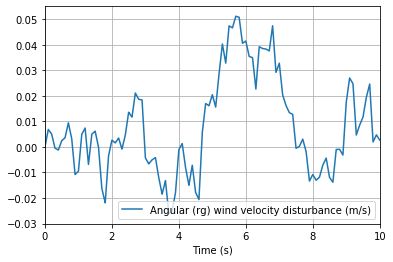

In [3]:
# the dryden noise class 
fig_num = 0;

class DrydenWindDisturbance:

    ################ STEP 1 - generate approximately gaussian white noise using the drake RandomSource class ####################

    #################################################################################################
    # STEP 2 - pass through a linear system to produce colored noise that matches the Dryden model 
    #################################################################################################

    ########################################### Dryden wind turbulence model ####################################################
    # Power Spectral Densities of the linear components of the wind velocities along the 3 axis. 
    #
    # linear wind velocities = (u_g, v_g, w_g)
    #
    # Linear PSDs:
    #
    # I_u (omega) = (sigma_u ** 2) * (2 L_u / pi ) * (1 / (1 + L_u * omega) ** 2) )
    #
    # I_v (omega) = (sigma_v ** 2) * (2 L_v / pi ) * (    (1 + 12 * (L_v * omega) ** 2 )  /  ( (1 + 4 * (L_v * omega) ** 2 ) ) ** 2 )     )
    #
    # I_w (omega) = (sigma_w ** 2) * (2 L_w / pi ) * (    (1 + 4 * (L_w * omega) ** 2 )  /  ( (1 + 12 * (L_w * omega) ** 2 ) ) ** 2 )     )
    #
    #
    #

    def __init__(self, sampling_interval):

        # define the number of outputs for the gaussian noise source used to generate 
        # Dryden wind disturbance
        self.sampling_interval = sampling_interval

    def calculate_model_parameters(self, altitude, wind_speed):
        #########################
        # turbulence intensities( sigma_u, sigma_v, sigma_w), and turbulence lengths (L_u, L_v, L_w) are 
        # functions of altitude h, divided into three regions:
        #
        # wind_speed = 15 knots for light turbulence, 30 knots for moderate turbulence, 
        # 45 knots for severe turbulence
        #
        ######################## Region 1: h < 1000
        # 
        # L_w = h
        # L_u = L_v = h / (0.177 + 0.000823h) ** 1.2
        # 
        # sigma_w = 0.1 * wind_speed
        # sigma_u / sigma_w = sigma_v / sigma_w = 1 / (0.177 + 0.000823h) ** 0.4
        # 
        #
        ######################### Region 2: 1000 < h < 2000
        #
        # Calculated be performing linear interpolation between regions 1 & 3
        # 
        #
        ######################### Region 3: h > 2000
        #
        # L_u = L_v = L_w = 1750
        #
        # sigmas are determined by a lookup table 
        #

        # units of altitude in ft
        if (altitude < 1000):

            sigma_w = 0.1 * wind_speed
            
            sigma_v  = sigma_w / ( (0.177 + 0.000823* altitude) ** 0.4 )

            sigma_u = sigma_v

            L_w = altitude

            L_v = altitude / ( (0.177 + 0.000823* altitude) ** 1.2 )

            L_u = L_v

        elif (1000 <= altitude <= 2000):
            print("altitude in region 2: 1000 - 2000 ft")
        # altitude > 2000ft
        else:
            print("altitude in region 3: > 2000 ft")

        return sigma_u, sigma_v, sigma_w, L_u, L_v, L_w

    
    def ug_filter(self, sigma_u, L_u, vehicle_speed):

        global fig_num

        # H_ug(s) = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed)) * (1 / (1 + L_u/V s))

        # define gain for transfer function that will produce PSD of the linear wind velocity in direction u)
        H_ug_gain = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed))
        print(f"H_ug_gain = {H_ug_gain}")
        
        #define lowpass filter that will produce longitudinal linear wind disturbance
        # highest order terms are first in the array

        H_ug_tf = signal.TransferFunction(H_ug_gain, [ L_u / vehicle_speed, 1] )

        print(H_ug_tf)

        w, H = signal.freqresp(H_ug_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Longitudinal wind disturbance forming filter frequency response, H_ug')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        #plt.xlabel('Frequency [rad/sec]')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_ug_ss = H_ug_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_ug_sys = LinearSystem(H_ug_ss.A, H_ug_ss.B, H_ug_ss.C, H_ug_ss.D )

        return self.H_ug_sys

    def vg_filter(self, sigma_v, L_v, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_vg_gain = sigma_v * np.sqrt(2* L_v / np.pi * vehicle_speed)
        
        print(f"H_vg_gain = {H_vg_gain}")

        # highest order terms are first in the array
        H_vg_tf = signal.TransferFunction([(H_vg_gain * 2 * np.sqrt(3) * L_v / vehicle_speed ), H_vg_gain ], \
        [(2*L_v/vehicle_speed)**2, 4*L_v/vehicle_speed, 1] )

        print(H_vg_tf)

        w, H = signal.freqresp(H_vg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Lateral wind disturbance forming filter frequency response, H_vg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_vg_ss = H_vg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_vg_sys = LinearSystem(H_vg_ss.A, H_vg_ss.B, H_vg_ss.C, H_vg_ss.D )

        return self.H_vg_sys

    def wg_filter(self, sigma_w, L_w, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_wg_gain = sigma_w * np.sqrt(2* L_w / np.pi * vehicle_speed)
        
        print(f"H_wg_gain = {H_wg_gain}")

        # highest order terms are first in the array
        H_wg_tf = signal.TransferFunction([(H_wg_gain * 2 * np.sqrt(3) * L_w / vehicle_speed ), H_wg_gain ], \
        [(2*L_w/vehicle_speed)**2, 4*L_w/vehicle_speed, 1] )

        print(H_wg_tf)

        w, H = signal.freqresp(H_wg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Vertical wind disturbance forming filter frequency response, H_wg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_wg_ss = H_wg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_wg_sys = LinearSystem(H_wg_ss.A, H_wg_ss.B, H_wg_ss.C, H_wg_ss.D )

        return self.H_wg_sys

    # define filter to generate angular wind disturbance velocity, pg = dwg/ dy
    def pg_filter(self, sigma_w, L_w, vehicle_speed, wing_span):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_pg_gain = sigma_w * np.sqrt(0.8 /  vehicle_speed) *  ((np.pi / 4 * wing_span) ** (1/6) )
        
        print(f"H_pg_gain = {H_pg_gain}")

        # highest order terms are first in the array
        H_pg_tf = signal.TransferFunction(H_pg_gain, [(2*L_w)**(1/3) * (4* wing_span / np.pi * vehicle_speed), (2*L_w)**(1/3)] )

        print(H_pg_tf)

        w, H = signal.freqresp(H_pg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Angular wind disturbance forming filter frequency response, H_pg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_pg_ss = H_pg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_pg_sys = LinearSystem(H_pg_ss.A, H_pg_ss.B, H_pg_ss.C, H_pg_ss.D )

        return self.H_pg_sys


    # define filter to generate angular wind disturbance velocity, qg = dwg/ dx
    def qg_filter(self, sigma_w, L_w, vehicle_speed, wing_span):

        global fig_num

        H_wg_gain = sigma_w * np.sqrt(2* L_w / np.pi * vehicle_speed)

        print(f"H_wg_gain = {H_wg_gain}")

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        num = [H_wg_gain * 2 * np.sqrt(3) * L_w / (vehicle_speed ** 2), H_wg_gain / vehicle_speed, 0 ]
        
        denom = [(4*wing_span / np.pi *vehicle_speed) * (2 * L_w / vehicle_speed)**2, \
        ( (2 * L_w / vehicle_speed)**2 + (4*wing_span / np.pi *vehicle_speed) * (4*L_w / vehicle_speed) ),\
        (4*L_w / vehicle_speed) + (4*wing_span / np.pi *vehicle_speed), \
        1 ]

        # highest order terms are first in the array
        H_qg_tf = signal.TransferFunction(num, denom )

        print(H_qg_tf)

        w, H = signal.freqresp(H_qg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Angular wind disturbance forming filter frequency response, H_qg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_qg_ss = H_qg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_qg_sys = LinearSystem(H_qg_ss.A, H_qg_ss.B, H_qg_ss.C, H_qg_ss.D )

        return self.H_qg_sys

    # define filter to generate angular wind disturbance velocity, rg = -dvg/ dx
    def rg_filter(self, sigma_v, L_v, vehicle_speed, wing_span):

        global fig_num

        H_vg_gain = sigma_v * np.sqrt(2* L_v / np.pi * vehicle_speed)

        print(f"H_vg_gain = {H_vg_gain}")

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        num = [-H_vg_gain * 2 * np.sqrt(3) * L_v / (vehicle_speed ** 2), -H_vg_gain / vehicle_speed, 0 ]
        
        denom = [(3*wing_span / np.pi *vehicle_speed) * (2 * L_v / vehicle_speed)**2, \
        ( (2 * L_v / vehicle_speed)**2 + (3*wing_span / np.pi *vehicle_speed) * (4*L_v / vehicle_speed) ),\
        (4*L_v / vehicle_speed) + (3*wing_span / np.pi *vehicle_speed), \
        1 ]

        # highest order terms are first in the array
        H_rg_tf = signal.TransferFunction(num, denom )

        print(H_rg_tf)

        w, H = signal.freqresp(H_rg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Angular wind disturbance forming filter frequency response, H_rg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_rg_ss = H_rg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_rg_sys = LinearSystem(H_rg_ss.A, H_rg_ss.B, H_rg_ss.C, H_rg_ss.D )

        return self.H_rg_sys




    

    def connect_Dryden_noise_src(self, builder):

        # define gaussiang random noise input
        gaussian_distribution = RandomDistribution(1) # parameter of 1 = gaussian distribution
        self.white_noise_src0 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src1 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src2 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src3 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src4 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src5 = RandomSource(gaussian_distribution, 1, self.sampling_interval)


        builder.AddSystem(self.white_noise_src0)
        builder.AddSystem(self.white_noise_src1)
        builder.AddSystem(self.white_noise_src2)
        builder.AddSystem(self.white_noise_src3)
        builder.AddSystem(self.white_noise_src4)
        builder.AddSystem(self.white_noise_src5)

        builder.AddSystem(self.H_ug_sys)
        builder.AddSystem(self.H_vg_sys)
        builder.AddSystem(self.H_wg_sys)
        builder.AddSystem(self.H_pg_sys)
        builder.AddSystem(self.H_qg_sys)
        builder.AddSystem(self.H_rg_sys)

        builder.Connect(self.white_noise_src0.get_output_port(0), self.H_ug_sys.get_input_port(0))
        builder.Connect(self.white_noise_src1.get_output_port(0), self.H_vg_sys.get_input_port(0))
        builder.Connect(self.white_noise_src2.get_output_port(0), self.H_wg_sys.get_input_port(0))
        builder.Connect(self.white_noise_src3.get_output_port(0), self.H_pg_sys.get_input_port(0))
        builder.Connect(self.white_noise_src4.get_output_port(0), self.H_qg_sys.get_input_port(0))
        builder.Connect(self.white_noise_src5.get_output_port(0), self.H_rg_sys.get_input_port(0))


        self.white_noise_src0.set_name("Gaussian White Noise Source 0")
        self.white_noise_src1.set_name("Gaussian White Noise Source 1")
        self.white_noise_src2.set_name("Gaussian White Noise Source 2")
        self.white_noise_src3.set_name("Gaussian White Noise Source 3")
        self.white_noise_src4.set_name("Gaussian White Noise Source 4")
        self.white_noise_src5.set_name("Gaussian White Noise Source 5")

        self.H_ug_sys.set_name("Longitudinal Wind Velocity Disturbance Forming Filter")
        self.H_vg_sys.set_name("Lateral Wind Velocity Disturbance Forming Filter")
        self.H_wg_sys.set_name("Vertical Wind Velocity Disturbance Forming Filter")
        self.H_pg_sys.set_name("Angular pg Wind Velocity Disturbance Forming Filter")
        self.H_qg_sys.set_name("Angular qg Wind Velocity Disturbance Forming Filter")
        self.H_rg_sys.set_name("Angular rg Wind Velocity Disturbance Forming Filter")

        return [self.white_noise_src0, self.white_noise_src1, self.white_noise_src2, self.white_noise_src3, \
        self.white_noise_src4, self.white_noise_src5]


# simulation time
sim_time = 10
time_step = 0.1

num_time_steps = int(sim_time / time_step)


sampling_interval = 0.1 # seconds
altitude = 100 #ft
wind_speed = 15 # m/s
vehicle_speed = 5 # m/s
# wingspan of quadrotor found in drake/examples/quadrotor/quadrotor.urdf
wing_span = 0.4 # m

dryden_noise = DrydenWindDisturbance(sampling_interval)

### Calculate Dryden model parameters
sigma_u, sigma_v, sigma_w, L_u, L_v, L_w = dryden_noise.calculate_model_parameters(altitude, wind_speed)

print(f"sigma_u = {sigma_u}, L_u = {L_u}") 
print(f"sigma_v = {sigma_v}, L_v = {L_v} ")
print(f"sigma_w = {sigma_w}, L_w = {L_w} ")
print(f"vehicle_speed = {vehicle_speed}")

##################################################################################
####### define the linear systems used to model wind velocity disturbances in each direction 
##################################################################################
H_ug_sys = dryden_noise.ug_filter(sigma_u, L_u, vehicle_speed)
H_vg_sys = dryden_noise.vg_filter(sigma_v, L_v, vehicle_speed)
H_wg_sys = dryden_noise.wg_filter(sigma_w, L_w, vehicle_speed)
H_pg_sys = dryden_noise.pg_filter(sigma_w, L_w, vehicle_speed, wing_span)
H_qg_sys = dryden_noise.qg_filter(sigma_w, L_w, vehicle_speed, wing_span)
H_rg_sys = dryden_noise.rg_filter(sigma_v, L_v, vehicle_speed, wing_span)


##################################################################################
####### define nominal velocity trajectory in X, Y, and Z directions #############
##################################################################################
breaks = [0, sim_time]
init_x_velocity = [1.5]
final_x_velocity = [-3.5]
init_y_velocity = [0.0]
final_y_velocity = [5.0]
init_z_velocity = [0.0]
final_z_velocity = [2.0]
x_samples = np.column_stack((init_x_velocity, final_x_velocity))
y_samples = np.column_stack((init_y_velocity, final_y_velocity))
z_samples = np.column_stack((init_z_velocity, final_z_velocity))
wind_vel_x_traj = PiecewisePolynomial.FirstOrderHold(breaks, x_samples)
wind_vel_y_traj = PiecewisePolynomial.FirstOrderHold(breaks, y_samples)
wind_vel_z_traj = PiecewisePolynomial.FirstOrderHold(breaks, z_samples)



builder = DiagramBuilder()



nom_wind_x_source = builder.AddSystem(TrajectorySource(wind_vel_x_traj))
nom_wind_y_source = builder.AddSystem(TrajectorySource(wind_vel_y_traj))
nom_wind_z_source = builder.AddSystem(TrajectorySource(wind_vel_z_traj))

logger_x = LogVectorOutput(nom_wind_x_source.get_output_port(), builder)
logger_x.set_name('nominal_x_wind_speed_Logger')
logger_y = LogVectorOutput(nom_wind_y_source.get_output_port(), builder)
logger_y.set_name('nominal_y_wind_speed_Logger')
logger_z = LogVectorOutput(nom_wind_z_source.get_output_port(), builder)
logger_z.set_name('nominal_z_wind_speed_Logger')



##################################################################################
####### Connect #############
##################################################################################

[white_noise_src0, white_noise_src1, white_noise_src2, white_noise_src3, \
        white_noise_src4, white_noise_src5]  = dryden_noise.connect_Dryden_noise_src(builder)

# logger that records the state trajectory during simulation
logger_ug = LogVectorOutput(H_ug_sys.get_output_port(), builder)
logger_ug.set_name('longitudinal wind_speed_disturbance_Logger')
logger_vg = LogVectorOutput(H_vg_sys.get_output_port(), builder)
logger_vg.set_name('lateral wind_speed_disturbance_Logger')
logger_wg = LogVectorOutput(H_wg_sys.get_output_port(), builder)
logger_wg.set_name('vertical wind_speed_disturbance_Logger')

logger_pg = LogVectorOutput(H_pg_sys.get_output_port(), builder)
logger_pg.set_name('angular pg wind_speed_disturbance_Logger')
logger_qg = LogVectorOutput(H_qg_sys.get_output_port(), builder)
logger_qg.set_name('angular qg wind_speed_disturbance_Logger')
logger_rg = LogVectorOutput(H_qg_sys.get_output_port(), builder)
logger_rg.set_name('angular rg wind_speed_disturbance_Logger')


# logger that records the state trajectory during simulation
logger_noise = LogVectorOutput(white_noise_src0.get_output_port(), builder)
logger_noise.set_name('noise_src_Logger')

diagram = builder.Build()

############### Visualize 
# give names to the blocks (just to make the plot nicer)
diagram.set_name('Block Diagram for Dryden Wind Disturbance Model')
# plot current diagram
plt.figure(fig_num, figsize=(20, 10))
fig_num += 1
plot_system_graphviz(diagram)


#Hug_Output = H_ug_sys.AllocateOutput()
#print(Hug_Output.num_ports())




# set up a simulator
simulator = Simulator(diagram)

context = simulator.get_mutable_context()
context.SetTime(0.) # reset current time

# simulate from zero to sim_time
simulator.Initialize()
sim_context = simulator.get_mutable_context()
while simulator.get_context().get_time() < sim_time:
    simulator.AdvanceTo(simulator.get_context().get_time() + time_step )


############### Plot gaussian noise source output ######################

plt.figure(fig_num)
fig_num +=1
# longitudinal wind velocity as a function of time
noise_log = logger_noise.FindLog(context)
plt.plot(
    noise_log.sample_times(),
    noise_log.data()[0,:],
    label='Gaussian noise source '
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()


############### Plot Nominal wind velocity, x direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_x = logger_x.FindLog(context)
plt.plot(
    log_x.sample_times(),
    log_x.data()[0,:],
    label='Nominal wind velocity, x (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

############### Plot Nominal wind velocity, y direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_y = logger_y.FindLog(context)
plt.plot(
    log_y.sample_times(),
    log_y.data()[0,:],
    label='Nominal wind velocity, y (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

############### Plot Nominal wind velocity, z direction ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_z = logger_z.FindLog(context)
plt.plot(
    log_z.sample_times(),
    log_z.data()[0,:],
    label='Nominal wind velocity, z (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()



############### Plot Longitudinal wind disturbance ######################


plt.figure(fig_num)
fig_num+=1

# longitudinal wind velocity as a function of time
log_ug = logger_ug.FindLog(context)
plt.plot(
    log_ug.sample_times(),
    log_ug.data()[0,:],
    label='Longitudinal wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()


############### Plot Lateral wind disturbance ######################

plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_vg = logger_vg.FindLog(context)
plt.plot(
    log_vg.sample_times(),
    log_vg.data()[0,:],
    label='Lateral wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()



############### Plot vertical wind disturbance ######################


plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_wg = logger_wg.FindLog(context)
plt.plot(
    log_wg.sample_times(),
    log_wg.data()[0,:],
    label='Vertical wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()





############### Plot angular pg wind disturbance ######################


plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_pg = logger_pg.FindLog(context)
plt.plot(
    log_pg.sample_times(),
    log_pg.data()[0,:],
    label='Angular (pg) wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()


############### Plot Angular qg wind disturbance ######################


plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_qg = logger_qg.FindLog(context)
plt.plot(
    log_qg.sample_times(),
    log_qg.data()[0,:],
    label='Angular (qg) wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

############### Plot Angular rg wind disturbance ######################

plt.figure(fig_num)
fig_num+=1
# longitudinal wind velocity as a function of time
log_rg = logger_rg.FindLog(context)
plt.plot(
    log_rg.sample_times(),
    log_rg.data()[0,:],
    label='Angular (rg) wind velocity disturbance (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

############### PSD of wind disturbance ######################

#print(len((log.data()[0,:])) )
#plt.figure(fig_num)
#fig_num +=1
#fs = vehicle_speed
#fs = 1.0
#f, PSD_ug = signal.welch(log_ug.data()[0,:], fs, nperseg=64)
#plt.semilogy(f, PSD_ug)
#plt.ylim([0.5e-3, 1])
#plt.xlabel('spatial frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
#plt.show()











## Define obstacle class &amp; Sim environment class

In [4]:
class Obstacle():

    def __init__(self, sdf, p, body_name):

        self.sdf = sdf
        self.position = p
        self.body_name = body_name


    #parse sdf file to instantiate object and weld it to the simulation world
    def connect_obstacle_to_world(self, obstacle_plant, scene_graph):

        parser = Parser(obstacle_plant, scene_graph)

        self.model_instance = parser.AddModelFromFile(self.sdf)
        self.body = obstacle_plant.GetBodyByName(self.body_name, self.model_instance)
        obstacle_plant.WeldFrames(obstacle_plant.world_frame(), self.body.body_frame(), RigidTransform(p=self.position))

    # calculate 3D distance vector from quadrotor to object
    # quad_state parameter is truncated version of full state [x,y,z]
    def distance_from_object(self, quad_state):
        return quad_state - self.position


class SimEnvironment:

    def __init__(self):
            #define diagram builder, used to connect plant and controller inputs / outputs
            self.builder = DiagramBuilder()

            #add plant, scene graph to builder
            self.obstacle_plant, self.scene_graph = AddMultibodyPlantSceneGraph(self.builder, time_step = 1.0)

            self.quadrotor_plant = self.builder.AddSystem(QuadrotorPlant())

            self.controller = self.builder.AddSystem(StabilizingLQRController(self.quadrotor_plant, [0.5,0, 0.5]))

    def setup_obstacles(self):

        self.obstacles = []

        self.obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[0.5, 0.6, 0.7],"tree_body"))
        self.obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[2, 1, 0.5], "tree_body"))
        self.obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[2, 3, 0.5], "tree_body"))
        
        for obs in self.obstacles:
            obs.connect_obstacle_to_world(self.obstacle_plant, self.scene_graph)
        

    def connect_systems(self):
        self.builder.Connect(self.controller.get_output_port(0), self.quadrotor_plant.get_input_port(0))
        self.builder.Connect(self.quadrotor_plant.get_output_port(0), self.controller.get_input_port(0))

    def setup_visualization(self):

        global meshcat

        # Set up visualization in MeshCat

        self.quad_geometry = QuadrotorGeometry.AddToBuilder(self.builder, self.quadrotor_plant.get_output_port(0), self.scene_graph)
        meshcat.Delete()
        meshcat.ResetRenderMode()
        meshcat.SetProperty('/Background','visible',False)
        # Add visualizer to visualize the geometries.
        self.visualizer = MeshcatVisualizerCpp.AddToBuilder(self.builder, self.scene_graph, meshcat,
            MeshcatVisualizerParams(role=Role.kPerception, prefix="visual"))

            
        # add collision visualizer
        #collision = MeshcatVisualizerCpp.AddToBuilder(
        #    builder, scene_graph, meshcat,
        #    MeshcatVisualizerParams(role=Role.kProximity, prefix="collision"))

        #meshcat.SetProperty("collision", "visible", True)
        # end setup for visualization

    def build_block_diagram(self):
        self.diagram = self.builder.Build()
        ############### Visualize 
        # give names to the blocks (just to make the plot nicer)
        self.diagram.set_name('Block Diagram for Quadrotor control')
        self.quadrotor_plant.set_name('Quadrotor Plant')
        self.quad_geometry.set_name("Quadrotor Geometry")
        self.controller.set_name('Stabilizing LQR Controller')
        self.scene_graph.set_name('Scene Graph')
        self.visualizer.set_name('Visualizer')

        # plot current diagram
        plt.figure(figsize=(20, 10))
        plot_system_graphviz(self.diagram)


    def run_sim(self):

        global meshcat
        
        # Set up a simulator to run this diagram
        simulator = Simulator(diagram)
        context = simulator.get_mutable_context()


        #continuous_state = context.get_mutable_continuous_state_vector()

        # Set the initial conditions (theta1, theta2, theta1dot, theta2dot)
        context.SetContinuousState([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

        # print(f"continuous state {continuous_state}")
        #print(f"size of continuous state {continuous_state.size()}")
        simulator.set_target_realtime_rate(0.5)
        meshcat.AddButton('Stop Simulation')
        while meshcat.GetButtonClicks('Stop Simulation') < 1:
            
            simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)

        meshcat.DeleteAddedControls()



## Non-Linear Trajectory Optimization for the Quadrotor

Find an optimal trajectory from an initial condition to a target destination, that minimizes time to target destination, and adheres to thrust limits




[Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous)]
[Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous)]
[Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous)]


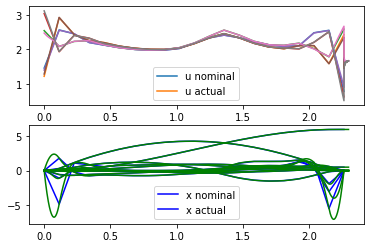

None

In [17]:
class QuadrotorTrajOpt():

    def __init__(self, init_state, target_state, num_time_samples, thrust_limit):
        self.init_state = init_state
        self.target_state = target_state
        self.num_time_samples = num_time_samples
        self.thrust_limit = thrust_limit

    def dir_col_opt(self, quadrotor_plant, quadrotor_context, obstacle_list):

        # use direct collocation to integrate quadrotor dynamics
        # DirectCollation classe performs Direct transcription trajectory optimization using nonlinear programming and collocation
        # It assumes a first-order hold on the input trajectory and a cubic spline representation of the state trajectory, and adds dynamic constraints 
        # (and running costs) to the midpoints as well as the breakpoints in order to achieve a 3rd order integration accuracy.
        dircol = DirectCollocation(quadrotor_plant,
                                quadrotor_context,
                                num_time_samples=self.num_time_samples,
                                minimum_timestep=0.05,
                                maximum_timestep=0.2)

        #Returns a reference to the MathematicalProgram associated with the trajectory optimization problem.
        prog = dircol.prog()

        # add constraint that enforces that all timesteps have equal duration (ensures more efficient optimization)
        dircol.AddEqualTimeIntervalsConstraints()

        # Returns placeholder decision variables (not actually declared as decision variables in the MathematicalProgram) 
        # associated with the input, u, but with the time-index undetermined.
        u = dircol.input()

        x = dircol.state()

        #print(f"state = {x}")
        #print(f"input = {u}")

        # enforce collision avoidance constraints for each obstacle

        for obs in obstacle_list:
            # pass [x,y,z] position of quadrotor to get distance vector 
            quad_state_xyz = x[:3]
            distance_vector = obs.distance_from_object(quad_state_xyz)
            #x distance from center of object
            dircol.AddConstraintToAllKnotPoints(np.linalg.norm(distance_vector) >= 1.0 )
        
        #enforce constraint that drone cannot fly underground
        dircol.AddConstraintToAllKnotPoints(x[2]>= 0)

        #enforce constraint drone cannot fly above tree line
        #dircol.AddConstraintToAllKnotPoints(x[2]<= 3)

        # enforce individual thrust limits for each propellor
        dircol.AddConstraintToAllKnotPoints(u[0] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[0])

        dircol.AddConstraintToAllKnotPoints(u[1] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[1])

        dircol.AddConstraintToAllKnotPoints(u[2] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[2])

        dircol.AddConstraintToAllKnotPoints(u[3] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[3])

        # add initial state constraint (first parameter is upper bound, second parameter is lower bound, 3rd parameter is variable being constrained)
        prog.AddBoundingBoxConstraint(self.init_state, self.init_state,
                                    dircol.initial_state())

        # add final state constraint
        prog.AddBoundingBoxConstraint(self.target_state, self.target_state,
                                    dircol.final_state())


        R = 100  # Cost on input "effort".
        dircol.AddRunningCost(R * u[0]**2)
        dircol.AddRunningCost(R * u[1]**2)
        dircol.AddRunningCost(R * u[2]**2)
        dircol.AddRunningCost(R * u[3]**2)

        # Add a final cost equal to the total duration.
        dircol.AddFinalCost(dircol.time())

        # Construct an initial guess at an optimal trajectory
        # PiecewisePolynomial.FirstOrderHold Constructs a piecewise linear PiecewisePolynomial using matrix samples.
        breaks = [0., 4.]
        samples = np.column_stack((self.init_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(breaks, samples)  # yapf: disable

        dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

        result = Solve(prog)
        assert (result.is_success())

        u_trajectory = dircol.ReconstructInputTrajectory(result)
        x_trajectory = dircol.ReconstructStateTrajectory(result)

        return u_trajectory, x_trajectory

    def create_lqr_stabilizer(self, x_trajectory, u_trajectory, quadrotor_plant, quadrotor_context, options):


        options.x0 = x_trajectory
        options.u0 = u_trajectory
        
        #define state penalty matrix with a 10 to 1 ratio on positions vs velocites
        #[x,y,z,roll,pitch,yaw, xdot, ydot, zdot, rolldot, pitchdot, yawdot]
        Q = np.diag([10.,10.,10.,10.,10.,10.,1.,1.,1.,1.,1.,1.])

        #final cost matrix
        options.Qf = Q
        # there are 4 thrust inputs, add minimum penalty to thrust
        R = np.eye(4)

        lqr_regulator = MakeFiniteHorizonLinearQuadraticRegulator(quadrotor_plant,
                                                  quadrotor_context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=R,
                                                  options=options)
        return lqr_regulator

#calculate optimal trajectory and simulation
initial_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# target state for trajectory optimization
final_state = [0, 6, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# limit of thrust force for each individual propellor
thrust_limit = 5.0
#we want to have an odd number
num_time_samples = 21


builder = DiagramBuilder()

quad_traj_opt = QuadrotorTrajOpt(initial_state, final_state, num_time_samples, thrust_limit)

obstacle_plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 1.0)

obstacles = []

obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[2, 2, 0.5],"tree_body"))
obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[-2, 2, 0.5], "tree_body"))
obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[0, 4, 0.5], "tree_body"))

for obs in obstacles:
    obs.connect_obstacle_to_world(obstacle_plant, scene_graph)

obstacle_plant.Finalize()


quadrotor_plant = QuadrotorPlant()
quadrotor_context = quadrotor_plant.CreateDefaultContext()

u_trajectory, x_trajectory = quad_traj_opt.dir_col_opt(quadrotor_plant, quadrotor_context, obstacles)

options = FiniteHorizonLinearQuadraticRegulatorOptions()
lqr_regulator = quad_traj_opt.create_lqr_stabilizer(x_trajectory, u_trajectory, quadrotor_plant, quadrotor_context, options)

lqr_regulator = builder.AddSystem(lqr_regulator)
quadrotor_plant = builder.AddSystem(quadrotor_plant)


builder.Connect(lqr_regulator.get_output_port(0), quadrotor_plant.get_input_port(0))
builder.Connect(quadrotor_plant.get_output_port(0), lqr_regulator.get_input_port(0))


input_logger = LogVectorOutput(lqr_regulator.get_output_port(0), builder)
state_logger = LogVectorOutput(quadrotor_plant.get_output_port(0), builder)


#source = builder.AddSystem(TrajectorySource(x_trajectory))

# Set up visualization in MeshCat
QuadrotorGeometry.AddToBuilder(builder, quadrotor_plant.get_output_port(0), scene_graph)
meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty('/Background','visible',False)
MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
# end setup for visualization

diagram = builder.Build()

end_time = options.u0.end_time()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()

#sim_context.SetContinuousState(initial_state)

simulator.set_target_realtime_rate(1.0)
meshcat.AddButton('Stop Simulation')
while simulator.get_context().get_time() < end_time:
    
    simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)

meshcat.DeleteAddedControls()


fig, ax = plt.subplots(2,1)
ax[0].plot(options.u0.get_segment_times(),
            options.u0.vector_values(options.u0.get_segment_times()).T)
input_log = input_logger.FindLog(simulator.get_context())
ax[0].plot(input_log.sample_times(), input_log.data().T)
ax[0].legend(('u nominal','u actual'))

ax[1].plot(options.x0.get_segment_times(),
            options.x0.vector_values(options.x0.get_segment_times()).T, 'b')
state_log = state_logger.FindLog(simulator.get_context())
ax[1].plot(state_log.sample_times(), state_log.data().T, 'g')
ax[1].legend(('x nominal','x actual'))
display(plt.show())



    


## Setup Environment and Run Simulation

KeyboardInterrupt: 

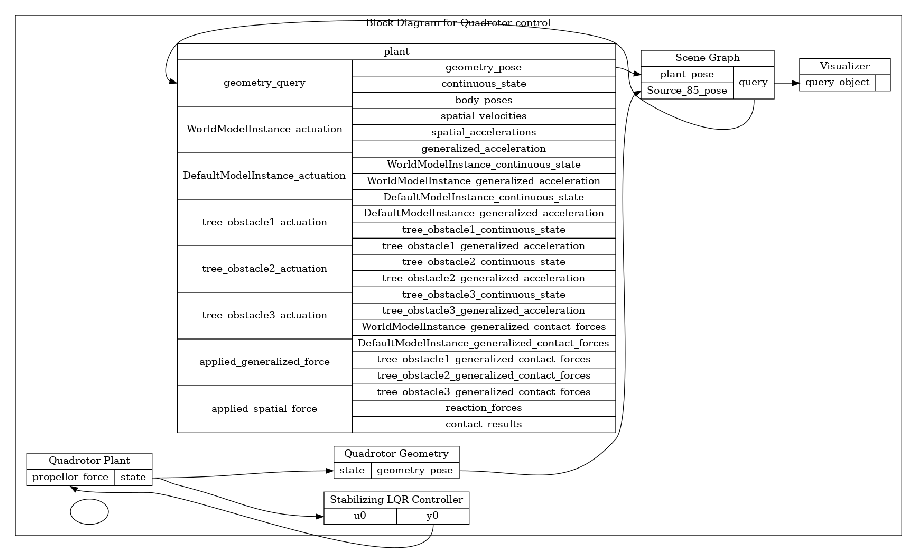

In [ ]:
###### Initialization of plants and controllers to be added to diagram builder #############

#define diagram builder, used to connect plant and controller inputs / outputs

builder = DiagramBuilder()

#add plant, scene graph to builder

obstacle_plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 1.0)

quadrotor_plant = builder.AddSystem(QuadrotorPlant())

controller = builder.AddSystem(StabilizingLQRController(quadrotor_plant, [0.5,0, 0.5]))


############ Setup Obstacles #################

obstacles = []

obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[0.5, 0.6, 0.7],"tree_body"))
obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[2, 1, 0.5], "tree_body"))
obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[2, 3, 0.5], "tree_body"))

for obs in obstacles:
    obs.connect_obstacle_to_world(obstacle_plant, scene_graph)

obstacle_plant.Finalize()


########## Connect components of block diagram ##########

builder.Connect(controller.get_output_port(0), quadrotor_plant.get_input_port(0))
builder.Connect(quadrotor_plant.get_output_port(0), controller.get_input_port(0))



############### Setup Visualization #################


# Set up visualization in MeshCat

quad_geometry = QuadrotorGeometry.AddToBuilder(builder, quadrotor_plant.get_output_port(0), scene_graph)
meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty('/Background','visible',False)
# Add visualizer to visualize the geometries.
visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat,
    MeshcatVisualizerParams(role=Role.kPerception, prefix="visual"))

    
# add collision visualizer
#collision = MeshcatVisualizerCpp.AddToBuilder(
#    builder, scene_graph, meshcat,
#    MeshcatVisualizerParams(role=Role.kProximity, prefix="collision"))

#meshcat.SetProperty("collision", "visible", True)
# end setup for visualization



################ Build block diagram and visualiz ####################
diagram = builder.Build()
############### Visualize 
# give names to the blocks (just to make the plot nicer)
diagram.set_name('Block Diagram for Quadrotor control')
quadrotor_plant.set_name('Quadrotor Plant')
quad_geometry.set_name("Quadrotor Geometry")
controller.set_name('Stabilizing LQR Controller')
scene_graph.set_name('Scene Graph')
visualizer.set_name('Visualizer')

# plot current diagram
plt.figure(figsize=(20, 10))
plot_system_graphviz(diagram)


########## Run Simulation ##################


# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()


#continuous_state = context.get_mutable_continuous_state_vector()

# Set the initial conditions (theta1, theta2, theta1dot, theta2dot)
context.SetContinuousState([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# print(f"continuous state {continuous_state}")
#print(f"size of continuous state {continuous_state.size()}")
simulator.set_target_realtime_rate(0.5)
meshcat.AddButton('Stop Simulation')
while meshcat.GetButtonClicks('Stop Simulation') < 1:
    
    simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)

meshcat.DeleteAddedControls()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7a2da9b8-cd38-4703-b181-4b0e0b197067' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>